# Define otsu thresholds

In [1]:
#!/usr/bin/env python

### load libs
import argparse
import gzip
import logging
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

# from uncertainties import ufloat
import matplotlib.pylab as plt
import bisect
import random
from collections import Counter
from collections.abc import Sequence
import seaborn as sns
import polars as pl

In [2]:
pl.__version__

'0.17.11'

In [3]:
import scipy

In [4]:
thresholds_dict = {
    "VIB_10xv1_1.FULL": 2438.1853173403856,
    "VIB_10xv1_2.FULL": 806.6280738610428,
    "CNA_10xv11_1.FULL": 1850.4818195858697,
    "CNA_10xv11_2.FULL": 1826.2007152445776,
    "CNA_10xv11_3.FULL": 1831.8597263142601,
    "CNA_10xv11_4.FULL": 2438.6621380919364,
    "CNA_10xv11_5.FULL": 1971.1300858593872,
    "STA_10xv11_1.FULL": 857.3331937428668,
    "STA_10xv11_2.FULL": 689.8865843199699,
    "TXG_10xv11_1.FULL": 3339.2929958428103,
    "CNA_10xv2_1.FULL": 1615.7244451504116,
    "CNA_10xv2_2.FULL": 1636.2210369844165,
    "TXG_10xv2_1.FULL": 1743.892251425405,
    "TXG_10xv2_2.FULL": 1715.1146916724465,
    "VIB_10xv2_1.FULL": 1937.2004417284827,
    "VIB_10xv2_2.FULL": 2250.5763636866923,
    "CNA_10xmultiome_1.FULL": 1455.3981817372642,
    "CNA_10xmultiome_2.FULL": 1392.245595801223,
    "SAN_10xmultiome_1.FULL": 2870.948395046649,
    "SAN_10xmultiome_2.FULL": 2742.990627700091,
    "VIB_10xmultiome_1.FULL": 641.9245801520543,
    "VIB_10xmultiome_2.FULL": 731.3588597155177,
    "BRO_mtscatac_1.FULL": 1641.2536494457697,
    "BRO_mtscatac_2.FULL": 1678.7587129759263,
    "CNA_mtscatac_1.FULL": 1755.4862717440835,
    "CNA_mtscatac_2.FULL": 2021.4974611563973,
    "MDC_mtscatac_1.FULL": 1802.583436067427,
    "MDC_mtscatac_2.FULL": 1758.823229663951,
    "BIO_ddseq_1.FULL": 3414.8061190440662,
    "BIO_ddseq_2.FULL": 1942.5351886920175,
    "BIO_ddseq_3.FULL": 1668.6748733275485,
    "BIO_ddseq_4.FULL": 1805.559583765079,
    "HAR_ddseq_1.FULL": 2034.5326379339676,
    "HAR_ddseq_2.FULL": 1892.784297002315,
    "UCS_ddseq_1.FULL": 1378.5526577091782,
    "UCS_ddseq_2.FULL": 1427.7469029022277,
    "OHS_s3atac_1.FULL": 2061.4792868053364,
    "OHS_s3atac_2.FULL": 6030.103425892208,
    "CNA_hydrop_1.FULL": 746.4842324736906,
    "CNA_hydrop_2.FULL": 755.1807208553532,
    "CNA_hydrop_3.FULL": 822.9613057556605,
    "EPF_hydrop_1.FULL": 1236.939204857672,
    "EPF_hydrop_2.FULL": 1243.3922622043906,
    "EPF_hydrop_3.FULL": 1265.8329356662955,
    "EPF_hydrop_4.FULL": 1312.2039806737573,
    "VIB_hydrop_1.FULL": 1420.4998345174151,
    "VIB_hydrop_2.FULL": 1480.3578479177986,
}

In [5]:
df_reads = pd.read_csv("R1_lengths.FULL.sorted.txt", sep="\t", header=None)
df_reads.columns = ["fastq", "reads"]
df_reads.index = [x.split("/")[-1].split("__")[0] + ".FULL" for x in df_reads["fastq"]]
df_reads

,fastq,reads
BIO_ddseq_1.FULL,full_fastq/BIO_ddseq_1__R1.FULL.fastq.gz,2496461262
BIO_ddseq_2.FULL,full_fastq/BIO_ddseq_2__R1.FULL.fastq.gz,586078378
BIO_ddseq_3.FULL,full_fastq/BIO_ddseq_3__R1.FULL.fastq.gz,114310431
BIO_ddseq_4.FULL,full_fastq/BIO_ddseq_4__R1.FULL.fastq.gz,117075800
BRO_mtscatac_1.FULL,full_fastq/BRO_mtscatac_1__R1.FULL.fastq.gz,146150399
BRO_mtscatac_2.FULL,full_fastq/BRO_mtscatac_2__R1.FULL.fastq.gz,170806444
CNA_10xmultiome_1.FULL,full_fastq/CNA_10xmultiome_1__R1.FULL.fastq.gz,206430093
CNA_10xmultiome_2.FULL,full_fastq/CNA_10xmultiome_2__R1.FULL.fastq.gz,194200503
CNA_10xv11_1.FULL,full_fastq/CNA_10xv11_1__R1.FULL.fastq.gz,235409552
CNA_10xv11_2.FULL,full_fastq/CNA_10xv11_2__R1.FULL.fastq.gz,266533885


In [6]:
df_reads.at["VIB_hydrop_1.FULL", "reads"] = (
    df_reads.at["VIB_hydrop_11.FULL", "reads"]
    + df_reads.at["VIB_hydrop_12.FULL", "reads"]
)
df_reads.at["VIB_hydrop_2.FULL", "reads"] = (
    df_reads.at["VIB_hydrop_21.FULL", "reads"]
    + df_reads.at["VIB_hydrop_22.FULL", "reads"]
)

# now plot

In [7]:
# Fractions for which to sample from the fragments file:
#     [
#         float(f'{sampling_fraction:0.2f}')
#         for sampling_fraction in list(np.concatenate((np.arange(0.0, 0.5, 0.1), np.arange(0.5, 0.9, 0.05), np.arange(0.9, 1.01, 0.02))))
#     ]
sampling_fractions_default = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.92,
    0.94,
    0.96,
    0.98,
    1.0,
]


### initialise function and classes

In [8]:
### initialise function and classes


def read_bc_and_counts_from_fragments_file(fragments_bed_filename: str) -> pl.DataFrame:
    """
    Read cell barcode (column 4) and counts per fragment (column 5) from fragments BED file.
    Cell barcodes will appear more than once as they have counts per fragment, but as
    the fragment locations are not needed, they are not returned.

    Parameters
    ----------
    fragments_bed_filename: Fragments BED filename.

    Returns
    -------
    Polars dataframe with cell barcode and count per fragment (column 4 and 5 of BED file).
    """

    bed_column_names = (
        "Chromosome",
        "Start",
        "End",
        "Name",
        "Score",
        "Strand",
        "ThickStart",
        "ThickEnd",
        "ItemRGB",
        "BlockCount",
        "BlockSizes",
        "BlockStarts",
    )

    # Set the correct open function depending if the fragments BED file is gzip compressed or not.
    open_fn = gzip.open if fragments_bed_filename.endswith(".gz") else open

    skip_rows = 0
    nbr_columns = 0

    with open_fn(fragments_bed_filename, "rt") as fragments_bed_fh:
        for line in fragments_bed_fh:
            # Remove newlines and spaces.
            line = line.strip()

            if not line or line.startswith("#"):
                # Count number of empty lines and lines which start with a comment before the actual data.
                skip_rows += 1
            else:
                # Get number of columns from the first real BED entry.
                nbr_columns = len(line.split("\t"))

                # Stop reading the BED file.
                break

    if nbr_columns < 5:
        raise ValueError(
            f'Fragments BED file needs to have at least 5 columns. "{fragments_bed_filename}" contains only '
            f"{nbr_columns} columns."
        )

    # Read cell barcode (column 4) and counts (column 5) per fragemnt from fragments BED file.
    fragments_df = pl.read_csv(
        fragments_bed_filename,
        has_header=False,
        skip_rows=skip_rows,
        separator="\t",
        use_pyarrow=False,
        n_threads=6,
        columns=["column_1", "column_2", "column_3", "column_4", "column_5"],
        new_columns=["Chromosome", "Start", "End", "CellBarcode", "FragmentCount"],
        dtypes=[pl.Categorical, pl.UInt32, pl.UInt32, pl.Categorical, pl.UInt32],
    )

    return fragments_df


def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y


# sub-sampling function
def sub_sample_fragments(
    fragments_df,
    min_uniq_frag=200,
    sampling_fractions=sampling_fractions_default,
    stats_tsv_filename="sampling_stats.tsv",
    whitelist=None,
):
    sampling_fractions_length = len(sampling_fractions)

    # Initialize dataframe for storing all statistics results.
    stats_df = pd.DataFrame(
        {
            "mean_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "median_uniq_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "total_frag_count": np.zeros(sampling_fractions_length, np.uint32),
            "cell_barcode_count": np.zeros(sampling_fractions_length, np.uint32),
            "duplication_rate": np.zeros(sampling_fractions_length, np.uint32),
        },
        index=pd.Index(data=np.array(sampling_fractions), name="sampling_fraction"),
    )

    # Get all cell barcodes which have more than min_uniq_frag fragments.
    good_cell_barcodes = (
        fragments_df.groupby("CellBarcode")
        .agg(pl.col("FragmentCount").count().alias("nbr_frags_per_CBs"))
        .filter(pl.col("nbr_frags_per_CBs") > min_uniq_frag)
    )

    # Count all good cell barcodes.
    nbr_good_cell_barcodes = good_cell_barcodes.height

    if 1.0 in sampling_fractions:
        # As there is no need to sample when sampling fraction is 100%,
        # the median number of unique fragments per barcode can be
        # calculated much more efficiently on the original fragments
        # file dataframe with counts than the expanded one, which is
        # needed when sampling is required.

        print("Calculate statistics for sampling fraction 100.0%.")

        print(f"Keep fragments with good barcodes.")
        fragments_for_good_bc_df = good_cell_barcodes.join(
            fragments_df, left_on="CellBarcode", right_on="CellBarcode", how="left"
        )

        print("Calculate total number of fragments.")
        stats_df.loc[1.0, "total_frag_count"] = fragments_for_good_bc_df.select(
            [pl.col("FragmentCount").sum().alias("TotalFragCount")]
        )["TotalFragCount"][0]

        print(
            "Calculate mean number of fragments per barcode and median number of unique fragments per barcode."
        )
        stats_df_pl = (
            fragments_for_good_bc_df.groupby("CellBarcode")
            .agg(
                [
                    pl.col("FragmentCount").sum().alias("MeanFragmentsPerCB"),
                    pl.count().alias("UniqueFragmentsPerCB"),
                ]
            )
            .select(
                [
                    pl.col("MeanFragmentsPerCB").mean(),
                    pl.col("UniqueFragmentsPerCB").median(),
                ]
            )
        )

        stats_df.loc[1.0, "mean_frag_per_bc"] = stats_df_pl["MeanFragmentsPerCB"][0]
        stats_df.loc[1.0, "median_uniq_frag_per_bc"] = stats_df_pl[
            "UniqueFragmentsPerCB"
        ][0]
        stats_df.loc[1.0, "cell_barcode_count"] = nbr_good_cell_barcodes
        total_fragments = total_fragments = fragments_df.select(
            pl.col("FragmentCount").sum()
        ).item()
        unique_fragments = fragments_df.height
        duplication_rate = (total_fragments - unique_fragments) / total_fragments
        stats_df.loc[1.0, "duplication_rate"] = duplication_rate

        # Delete dataframe to free memory.
        del fragments_for_good_bc_df

    # Create dataframe where each row contains one fragment:
    #   - Original dataframe has a count per fragment with the same cell barcode.
    #   - Create a row for each count, so we can sample fairly afterwards.
    print("Create dataframe with all fragments (for sampling).")
    fragments_all_df = fragments_df.with_columns(
        pl.col("FragmentCount").repeat_by(pl.col("FragmentCount"))
    ).explode("FragmentCount")

    # Delete input dataframe to free memory.
    del fragments_df

    for sampling_fraction in sampling_fractions:
        if sampling_fraction == 0.0:
            # All statistics are zero and already set when the stats_df dataframe is created.
            continue
        elif sampling_fraction == 1.0:
            # Statistics for 100% sampling are already calculated as there is no need
            # to have the fragments_all_df dataframe as no sampling is needed.
            # This avoids the need to use the expensive groupby operations for the
            # calculations of the median number of unique fragments per barcode.
            continue

        print(
            f"Calculate statistics for sampling fraction {round(sampling_fraction * 100, 1)}%."
        )

        # Sample x% from all fragments (with duplicates) and keep fragments which have good barcodes.
        print(
            f"Sample {round(sampling_fraction * 100, 1)}% from all fragments and keep fragments with good barcodes."
        )
        fragments_sampled_for_good_bc_df = good_cell_barcodes.join(
            fragments_all_df.sample(frac=sampling_fraction),
            left_on="CellBarcode",
            right_on="CellBarcode",
            how="left",
        )

        # Get number of sampled fragments (with possible duplicate fragments) which have good barcodes.
        stats_df.loc[
            sampling_fraction, "total_frag_count"
        ] = fragments_sampled_for_good_bc_df.height

        print("Calculate mean number of fragments per barcode.")
        stats_df.loc[sampling_fraction, "mean_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.select(
                [pl.col("CellBarcode"), pl.col("FragmentCount")]
            )
            .groupby("CellBarcode")
            .agg([pl.count("FragmentCount").alias("FragmentsPerCB")])
            .select([pl.col("FragmentsPerCB").mean().alias("MeanFragmentsPerCB")])[
                "MeanFragmentsPerCB"
            ][0]
        )

        print("Calculate median number of unique fragments per barcode.")
        stats_df.loc[sampling_fraction, "median_uniq_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.col("FragmentCount").first().alias("FragmentCount")])
            .select([pl.col("CellBarcode"), pl.col("FragmentCount")])
            .groupby("CellBarcode")
            .agg(pl.col("FragmentCount").count().alias("UniqueFragmentsPerCB"))
            .select(pl.col("UniqueFragmentsPerCB").median())["UniqueFragmentsPerCB"][0]
        )

        stats_df.loc[sampling_fraction, "cell_barcode_count"] = nbr_good_cell_barcodes

        total_fragments = total_fragments = fragments_df.select(
            pl.col("FragmentCount").sum()
        ).item()
        unique_fragments = fragments_df.height
        duplication_rate = (total_fragments - unique_fragments) / total_fragments
        stats_df.loc[sampling_fraction, "duplication_rate"] = duplication_rate

        # Delete dataframe to free memory.
        del fragments_sampled_for_good_bc_df

    print(f'Saving statistics in "{stats_tsv_filename}".')
    stats_df.to_csv(stats_tsv_filename, sep="\t")

    return stats_df


# Format axis labels
def format_axis(text):
    format_dict = {
        "mean_frag_per_bc": "Mean fragments / barcode",
        "median_uniq_frag_per_bc": "Median unique fragments / barcode",
        "total_frag_count": "Total fragment count",
        "total_reads_per_barcode": "Mean reads / barcode",
    }
    for i, j in format_dict.items():
        text = text.replace(i, j)
    return text


# MM-fit function
def fit_MM(
    stats_df,
    percentages=[0.3, 0.6, 0.9],
    saturation_plot_filename="saturation.png",
    x_axis="total_frag_count",
    y_axis="median_uniq_frag_per_bc",
):
    # select x/y data fro MM fit from subsampling stats
    x_data = np.array(stats_df.loc[:, x_axis]) / 10 ** 6
    y_data = np.array(stats_df.loc[:, y_axis])
    # fit to MM function
    best_fit_ab, covar = curve_fit(MM, x_data, y_data, bounds=(0, +np.inf))
    # expand fit space
    x_fit = np.linspace(0, int(np.max(x_data) * 100), num=500)
    y_fit = MM(x_fit, *(best_fit_ab))
    # impute maximum saturation to plot as 95% of y_max
    y_val = best_fit_ab[0] * 0.95
    # subset x_fit space if bigger then y_val
    if y_val < max(y_fit):
        x_coef = np.where(y_fit >= y_val)[0][0]
        x_fit = x_fit[0:x_coef]
        y_fit = y_fit[0:x_coef]
    # plot model
    plt.plot(x_fit, MM(x_fit, *best_fit_ab), label="fitted", c="black", linewidth=1)
    # plot raw data
    plt.scatter(x=x_data, y=y_data, c="crimson", s=10)
    # mark curent saturation
    x_idx = np.where(y_fit >= max(y_data))[0][0]
    x_coef = x_fit[x_idx]
    y_coef = y_fit[x_idx]
    plt.plot([x_coef, x_coef], [0, y_coef], linestyle="--", c="crimson")
    plt.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="crimson")
    plt.text(
        x=x_fit[-1],
        y=y_coef,
        s=str(round(100 * max(y_data) / best_fit_ab[0])) + "% {:.2f}".format(x_coef),
        c="crimson",
        ha="right",
        va="bottom",
    )
    # plot percentaged values
    for perc in percentages:
        # Find read count for percent saturation
        y_val = best_fit_ab[0] * perc
        # Find closest match in fit
        if max(y_fit) > y_val:
            x_idx = np.where(y_fit >= y_val)[0][0]
            x_coef = x_fit[x_idx]
            y_coef = y_fit[x_idx]
            # Draw vline
            plt.plot([x_coef, x_coef], [0, y_coef], linestyle="--", c="grey")
            # Draw hline
            plt.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="grey")
            # Plot imputed read count
            plt.text(
                x=x_fit[-1],
                y=y_coef,
                s=str(round(100 * perc)) + "% {:.2f}".format(x_coef),
                c="grey",
                ha="right",
                va="bottom",
            )
    # save figure
    plt.xlabel(format_axis(x_axis) + " (millions)")
    plt.ylabel(format_axis(y_axis))
    plt.title(os.path.basename(saturation_plot_filename).replace(".saturation.png", ""))
    plt.savefig(saturation_plot_filename)
    plt.close()


def main():
    sampling_fractions_default_str = ",".join(
        [str(x) for x in sampling_fractions_default]
    )

    parser = argparse.ArgumentParser(
        description="Infer saturation of scATAC from fragments file."
    )
    parser.add_argument(
        "-i",
        "--input",
        dest="fragments_input_bed_filename",
        action="store",
        type=str,
        required=True,
        help="Fragment input BED filename.",
    )
    parser.add_argument(
        "-o",
        "--output",
        dest="output_prefix",
        action="store",
        type=str,
        required=True,
        help="Output prefix, which will contain PNG file with saturation curve and TSV file with summary of "
        "reads and additional reads needed to reach saturation specified by percentages.",
    )
    parser.add_argument(
        "-p",
        "--percentages",
        dest="percentages",
        type=str,
        help='Comma separated list of decimal percentages to predict. Default: "0.3,0.6,0.9"',
        default="0.3,0.6,0.9",
    )
    parser.add_argument(
        "-m",
        "--min_frags_per_cb",
        dest="min_frags_per_cb",
        type=int,
        help="Minimum number of unique fragments per cell barcodes. Default: 200",
        default=200,
    )
    parser.add_argument(
        "-s",
        "--sampling_fractions",
        dest="sampling_fractions",
        type=str,
        help=f'Fractions at which to perform the sub-samplings. Default: "{sampling_fractions_default_str}"',
        default=sampling_fractions_default_str,
    )
    parser.add_argument(
        "-w",
        "--whitelist",
        dest="whitelist",
        type=str,
        help="Barcode whitelist filename.",
        default=None,
    )

    parser.add_argument("-V", "--version", action="version", version=f"{__version__}")

    args = parser.parse_args()

    sampling_fractions = [float(x) for x in args.sampling_fractions.split(",")]
    percentages = [float(x) for x in args.percentages.split(",")]

    # Enable global string cache.
    pl.toggle_string_cache(True)

    # Load fragments BED file.
    print("Loading fragments BED file started.")
    fragments_df = read_bc_and_counts_from_fragments_file(
        args.fragments_input_bed_filename
    )
    print("Loading fragments BED file finished.")

    # Sub-sample.
    stats_df = sub_sample_fragments(
        fragments_df,
        min_uniq_frag=args.min_frags_per_cb,
        sampling_fractions=sampling_fractions,
        stats_tsv_filename=args.output_prefix + ".sampling_stats.tsv",
        whitelist=args.whitelist,
    )

    print("fit_MM.")
    # Fit'n'plot for total count.
    fit_MM(
        stats_df,
        percentages=percentages,
        saturation_plot_filename=args.output_prefix + ".saturation.png",
        x_axis="total_frag_count",
        y_axis="median_uniq_frag_per_bc",
    )
    print("Finished.")

In [9]:
import glob

In [10]:
fragments_path_dict = {
    x.split("/")[-1].split(".")[0] + ".FULL": x
    for x in sorted(glob.glob("full_fragments/*.fragments.tsv.gz"))
}
fragments_path_dict.pop("VIB_hydrop_11.FULL")
fragments_path_dict.pop("VIB_hydrop_12.FULL")
fragments_path_dict.pop("VIB_hydrop_21.FULL")
fragments_path_dict.pop("VIB_hydrop_22.FULL")
fragments_path_dict.pop("CNA_ddseq_1.FULL")
fragments_path_dict.pop("CNA_ddseq_2.FULL")
fragments_path_dict

{'BIO_ddseq_1.FULL': 'full_fragments/BIO_ddseq_1.FULL.fragments.tsv.gz',
 'BIO_ddseq_2.FULL': 'full_fragments/BIO_ddseq_2.FULL.fragments.tsv.gz',
 'BIO_ddseq_3.FULL': 'full_fragments/BIO_ddseq_3.FULL.fragments.tsv.gz',
 'BIO_ddseq_4.FULL': 'full_fragments/BIO_ddseq_4.FULL.fragments.tsv.gz',
 'BRO_mtscatac_1.FULL': 'full_fragments/BRO_mtscatac_1.FULL.fragments.tsv.gz',
 'BRO_mtscatac_2.FULL': 'full_fragments/BRO_mtscatac_2.FULL.fragments.tsv.gz',
 'CNA_10xmultiome_1.FULL': 'full_fragments/CNA_10xmultiome_1.FULL.fragments.tsv.gz',
 'CNA_10xmultiome_2.FULL': 'full_fragments/CNA_10xmultiome_2.FULL.fragments.tsv.gz',
 'CNA_10xv11_1.FULL': 'full_fragments/CNA_10xv11_1.FULL.fragments.tsv.gz',
 'CNA_10xv11_2.FULL': 'full_fragments/CNA_10xv11_2.FULL.fragments.tsv.gz',
 'CNA_10xv11_3.FULL': 'full_fragments/CNA_10xv11_3.FULL.fragments.tsv.gz',
 'CNA_10xv11_4.FULL': 'full_fragments/CNA_10xv11_4.FULL.fragments.tsv.gz',
 'CNA_10xv11_5.FULL': 'full_fragments/CNA_10xv11_5.FULL.fragments.tsv.gz',
 'CNA

In [11]:
percentages = [0.3, 0.6, 0.9]
y_axis = "median_uniq_frag_per_bc"
x_axis = "total_reads_per_barcode"
# Enable global string cache.
pl.toggle_string_cache(True)

# Load fragments BED file.

/tmp/ipykernel_607794/1065562191.py:5: DeprecationWarning: `toggle_string_cache` has been renamed; this redirect is temporary, please use `enable_string_cache` instead
  pl.toggle_string_cache(True)


In [12]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]
tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1 (control)",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "mtscATAC-seq (FACS)",
    "s3atac": "s3-ATAC",
}

In [13]:
def sub_sample_fragments(
    fragments_df,
    min_uniq_frag=200,
    selected_barcodes=[],
    sampling_fractions=sampling_fractions_default,
    stats_tsv_filename="sampling_stats.tsv",
    whitelist=None,
):
    sampling_fractions_length = len(sampling_fractions)

    # Initialize dataframe for storing all statistics results.
    stats_df = pd.DataFrame(
        {
            "mean_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "median_uniq_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "total_unique_frag_count": np.zeros(sampling_fractions_length, np.uint32),
            "total_frag_count": np.zeros(sampling_fractions_length, np.uint32),
            "cell_barcode_count": np.zeros(sampling_fractions_length, np.uint32),
        },
        index=pd.Index(data=np.array(sampling_fractions), name="sampling_fraction"),
    )

    # Get all cell barcodes which have more than min_uniq_frag fragments.
    if not selected_barcodes:
        selected_barcodes = (
            fragments_df.groupby("CellBarcode")
            .agg(pl.col("FragmentCount").count().alias("nbr_frags_per_CBs"))
            .filter(pl.col("nbr_frags_per_CBs") > min_uniq_frag)
        )
    else:
        selected_barcodes = pl.DataFrame(
            [
                pl.Series("CellBarcode", selected_barcodes, dtype=pl.Categorical),
            ]
        )

    # Count all good cell barcodes.
    nbr_selected_barcodes = selected_barcodes.height

    if 1.0 in sampling_fractions:
        # As there is no need to sample when sampling fraction is 100%,
        # the median number of unique fragments per barcode can be
        # calculated much more efficiently on the original fragments
        # file dataframe with counts than the expanded one, which is
        # needed when sampling is required.

        print("Calculate statistics for sampling fraction 100.0%.")

        print(f"Keep fragments with good barcodes.")
        fragments_for_good_bc_df = selected_barcodes.join(
            fragments_df, left_on="CellBarcode", right_on="CellBarcode", how="left"
        )

        print("Calculate total number of fragments.")

        stats_df.loc[1.0, "total_unique_frag_count"] = (
            fragments_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.first("Start").alias("Start_tmp")])
            .select(pl.count())
            .item()
        )

        stats_df.loc[1.0, "total_frag_count"] = fragments_for_good_bc_df.select(
            pl.col("FragmentCount").sum()
        ).item()

        print(
            "Calculate mean number of fragments per barcode and median number of unique"
            " fragments per barcode."
        )
        stats_df_pl = (
            fragments_for_good_bc_df.groupby("CellBarcode")
            .agg(
                [
                    pl.col("FragmentCount").sum().alias("MeanFragmentsPerCB"),
                    pl.count().alias("UniqueFragmentsPerCB"),
                ]
            )
            .select(
                [
                    pl.col("MeanFragmentsPerCB").mean(),
                    pl.col("UniqueFragmentsPerCB").median(),
                ]
            )
        )

        stats_df.loc[1.0, "mean_frag_per_bc"] = stats_df_pl["MeanFragmentsPerCB"][0]
        stats_df.loc[1.0, "median_uniq_frag_per_bc"] = stats_df_pl[
            "UniqueFragmentsPerCB"
        ][0]
        stats_df.loc[1.0, "cell_barcode_count"] = nbr_selected_barcodes

        # Delete dataframe to free memory.
        del fragments_for_good_bc_df

    # Create dataframe where each row contains one fragment:
    #   - Original dataframe has a count per fragment with the same cell barcode.
    #   - Create a row for each count, so we can sample fairly afterwards.
    print("Create dataframe with all fragments (for sampling).")
    fragments_all_df = fragments_df.with_columns(
        pl.col("FragmentCount").repeat_by(pl.col("FragmentCount"))
    ).explode("FragmentCount")

    # Delete input dataframe to free memory.
    del fragments_df

    for sampling_fraction in sampling_fractions:
        if sampling_fraction == 0.0:
            # All statistics are zero and already set when the stats_df dataframe is created.
            continue
        elif sampling_fraction == 1.0:
            # Statistics for 100% sampling are already calculated as there is no need
            # to have the fragments_all_df dataframe as no sampling is needed.
            # This avoids the need to use the expensive groupby operations for the
            # calculations of the median number of unique fragments per barcode.
            continue

        print(
            "Calculate statistics for sampling fraction"
            f" {round(sampling_fraction * 100, 1)}%."
        )

        # Sample x% from all fragments (with duplicates) and keep fragments which have good barcodes.
        print(
            f"Sample {round(sampling_fraction * 100, 1)}% from all fragments and keep"
            " fragments with good barcodes."
        )
        fragments_sampled_for_good_bc_df = selected_barcodes.join(
            fragments_all_df.sample(fraction=sampling_fraction),
            left_on="CellBarcode",
            right_on="CellBarcode",
            how="left",
        )

        # Get number of sampled fragments (with possible duplicate fragments) which have good barcodes.
        stats_df.loc[sampling_fraction, "total_unique_frag_count"] = (
            fragments_sampled_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.first("Start").alias("Start_tmp")])
            .select(pl.count())
            .item()
        )

        stats_df.loc[
            sampling_fraction, "total_frag_count"
        ] = fragments_sampled_for_good_bc_df.select(pl.count()).item()

        print("Calculate mean number of fragments per barcode.")
        stats_df.loc[sampling_fraction, "mean_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.select(
                [pl.col("CellBarcode"), pl.col("FragmentCount")]
            )
            .groupby("CellBarcode")
            .agg([pl.count("FragmentCount").alias("FragmentsPerCB")])
            .select([pl.col("FragmentsPerCB").mean().alias("MeanFragmentsPerCB")])[
                "MeanFragmentsPerCB"
            ][0]
        )

        print("Calculate median number of unique fragments per barcode.")
        stats_df.loc[sampling_fraction, "median_uniq_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.col("FragmentCount").first().alias("FragmentCount")])
            .select([pl.col("CellBarcode"), pl.col("FragmentCount")])
            .groupby("CellBarcode")
            .agg(pl.col("FragmentCount").count().alias("UniqueFragmentsPerCB"))
            .select(pl.col("UniqueFragmentsPerCB").median())["UniqueFragmentsPerCB"][0]
        )

        stats_df.loc[sampling_fraction, "cell_barcode_count"] = nbr_selected_barcodes

        # Delete dataframe to free memory.
        del fragments_sampled_for_good_bc_df

    print(f'Saving statistics in "{stats_tsv_filename}".')
    stats_df.to_csv(stats_tsv_filename, sep="\t")

    return stats_df


In [14]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [15]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob("saturation_stats/*.sampling_stats_updated.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_1.FULL': 'saturation_stats/BIO_ddseq_1.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_2.FULL': 'saturation_stats/BIO_ddseq_2.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_3.FULL': 'saturation_stats/BIO_ddseq_3.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_4.FULL': 'saturation_stats/BIO_ddseq_4.FULL.sampling_stats_updated.tsv',
 'BRO_mtscatac_1.FULL': 'saturation_stats/BRO_mtscatac_1.FULL.sampling_stats_updated.tsv',
 'BRO_mtscatac_2.FULL': 'saturation_stats/BRO_mtscatac_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xmultiome_1.FULL': 'saturation_stats/CNA_10xmultiome_1.FULL.sampling_stats_updated.tsv',
 'CNA_10xmultiome_2.FULL': 'saturation_stats/CNA_10xmultiome_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_1.FULL': 'saturation_stats/CNA_10xv11_1.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_2.FULL': 'saturation_stats/CNA_10xv11_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_3.FULL': 'saturation_stats/CNA_10xv11_3.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_4.FULL': '

In [16]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}

for tech in tech_order:
    fragments_path_dict = {
        x.split("/")[-1].split(".")[0] + ".FULL": x
        for x in sorted(glob.glob(f"full_fragments/*{tech}_*.fragments.tsv.gz"))
    }
    if tech == "hydrop":
        fragments_path_dict.pop("VIB_hydrop_11.FULL")
        fragments_path_dict.pop("VIB_hydrop_12.FULL")
        fragments_path_dict.pop("VIB_hydrop_21.FULL")
        fragments_path_dict.pop("VIB_hydrop_22.FULL")
    if tech == "ddseq":
        fragments_path_dict.pop("CNA_ddseq_1.FULL")
        fragments_path_dict.pop("CNA_ddseq_2.FULL")

    covar_dict_tmp = {}
    best_fit_ab_dict_tmp = {}
    x_fit_dict_tmp = {}
    y_fit_dict_tmp = {}

    for sample in list(fragments_path_dict.keys()):
        print(sample)
        n_reads = df_reads.loc[sample]["reads"]

        if not sample in sampling_stats_path_dict.keys():
            print(f"{sample} stats do not exist")

            frags_path = fragments_path_dict[sample]
            fragments_df = read_bc_and_counts_from_fragments_file(frags_path)

            # Sub-sample.
            stats_df = sub_sample_fragments(
                fragments_df,
                min_uniq_frag=thresholds_dict[sample],
                sampling_fractions=sampling_fractions,
                stats_tsv_filename=f"saturation_stats/{sample}.sampling_stats_updated2.tsv",
                # whitelist=args.whitelist,
            )

VIB_10xv1_1.FULL
VIB_10xv1_2.FULL
CNA_10xv11_1.FULL
CNA_10xv11_2.FULL
CNA_10xv11_3.FULL
CNA_10xv11_4.FULL
CNA_10xv11_5.FULL
STA_10xv11_1.FULL
STA_10xv11_2.FULL
TXG_10xv11_1.FULL
CNA_10xv2_1.FULL
CNA_10xv2_2.FULL
TXG_10xv2_1.FULL
TXG_10xv2_2.FULL
VIB_10xv2_1.FULL
VIB_10xv2_2.FULL
CNA_10xmultiome_1.FULL
CNA_10xmultiome_2.FULL
SAN_10xmultiome_1.FULL
SAN_10xmultiome_2.FULL
VIB_10xmultiome_1.FULL
VIB_10xmultiome_2.FULL
BRO_mtscatac_1.FULL
BRO_mtscatac_2.FULL
CNA_mtscatac_1.FULL
CNA_mtscatac_2.FULL
MDC_mtscatac_1.FULL
MDC_mtscatac_2.FULL
BIO_ddseq_1.FULL
BIO_ddseq_2.FULL
BIO_ddseq_3.FULL
BIO_ddseq_4.FULL
HAR_ddseq_1.FULL
HAR_ddseq_2.FULL
UCS_ddseq_1.FULL
UCS_ddseq_2.FULL
OHS_s3atac_1.FULL
OHS_s3atac_2.FULL
CNA_hydrop_1.FULL
CNA_hydrop_2.FULL
CNA_hydrop_3.FULL
EPF_hydrop_1.FULL
EPF_hydrop_2.FULL
EPF_hydrop_3.FULL
EPF_hydrop_4.FULL
VIB_hydrop_1.FULL
VIB_hydrop_2.FULL


In [17]:
samples_order_dict_bytech = {
    "10xmultiome": [
        "CNA_10xmultiome_1.FULL",
        "CNA_10xmultiome_2.FULL",
        "SAN_10xmultiome_1.FULL",
        "SAN_10xmultiome_2.FULL",
        "VIB_10xmultiome_1.FULL",
        "VIB_10xmultiome_2.FULL",
    ],
    "10xv1": ["VIB_10xv1_1.FULL", "VIB_10xv1_2.FULL"],
    "10xv11": [
        "CNA_10xv11_1.FULL",
        "CNA_10xv11_2.FULL",
        "CNA_10xv11_3.FULL",
        "CNA_10xv11_4.FULL",
        "CNA_10xv11_5.FULL",
        "STA_10xv11_1.FULL",
        "STA_10xv11_2.FULL",
        "TXG_10xv11_1.FULL",
    ],
    "10xv2": [
        "CNA_10xv2_1.FULL",
        "CNA_10xv2_2.FULL",
        "TXG_10xv2_1.FULL",
        "TXG_10xv2_2.FULL",
        "VIB_10xv2_1.FULL",
        "VIB_10xv2_2.FULL",
    ],
    "ddseq": [
        "BIO_ddseq_1.FULL",
        "BIO_ddseq_2.FULL",
        "BIO_ddseq_3.FULL",
        "BIO_ddseq_4.FULL",
        "HAR_ddseq_1.FULL",
        "HAR_ddseq_2.FULL",
        "UCS_ddseq_1.FULL",
        "UCS_ddseq_2.FULL",
    ],
    "hydrop": [
        "CNA_hydrop_1.FULL",
        "CNA_hydrop_2.FULL",
        "CNA_hydrop_3.FULL",
        "EPF_hydrop_1.FULL",
        "EPF_hydrop_2.FULL",
        "EPF_hydrop_3.FULL",
        "EPF_hydrop_4.FULL",
        "VIB_hydrop_1.FULL",
        "VIB_hydrop_2.FULL",
    ],
    "mtscatac": [
        "BRO_mtscatac_1.FULL",
        "BRO_mtscatac_2.FULL",
        "CNA_mtscatac_1.FULL",
        "CNA_mtscatac_2.FULL",
        "MDC_mtscatac_1.FULL",
        "MDC_mtscatac_2.FULL",
    ],
    "s3atac": ["OHS_s3atac_1.FULL", "OHS_s3atac_2.FULL"],
}

In [18]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob("saturation_stats/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_1.FULL': 'saturation_stats/BIO_ddseq_1.FULL.sampling_stats.tsv',
 'BIO_ddseq_2.FULL': 'saturation_stats/BIO_ddseq_2.FULL.sampling_stats.tsv',
 'BIO_ddseq_3.FULL': 'saturation_stats/BIO_ddseq_3.FULL.sampling_stats.tsv',
 'BIO_ddseq_4.FULL': 'saturation_stats/BIO_ddseq_4.FULL.sampling_stats.tsv',
 'BRO_mtscatac_1.FULL': 'saturation_stats/BRO_mtscatac_1.FULL.sampling_stats.tsv',
 'BRO_mtscatac_2.FULL': 'saturation_stats/BRO_mtscatac_2.FULL.sampling_stats.tsv',
 'CNA_10xmultiome_1.FULL': 'saturation_stats/CNA_10xmultiome_1.FULL.sampling_stats.tsv',
 'CNA_10xmultiome_2.FULL': 'saturation_stats/CNA_10xmultiome_2.FULL.sampling_stats.tsv',
 'CNA_10xv11_1.FULL': 'saturation_stats/CNA_10xv11_1.FULL.sampling_stats.tsv',
 'CNA_10xv11_2.FULL': 'saturation_stats/CNA_10xv11_2.FULL.sampling_stats.tsv',
 'CNA_10xv11_3.FULL': 'saturation_stats/CNA_10xv11_3.FULL.sampling_stats.tsv',
 'CNA_10xv11_4.FULL': 'saturation_stats/CNA_10xv11_4.FULL.sampling_stats.tsv',
 'CNA_10xv11_5.FULL': 'saturatio

10xv1
VIB_10xv1_1.FULL
VIB_10xv1_2.FULL
10xv11
CNA_10xv11_1.FULL
CNA_10xv11_2.FULL
CNA_10xv11_3.FULL
CNA_10xv11_4.FULL
CNA_10xv11_5.FULL
STA_10xv11_1.FULL
STA_10xv11_2.FULL
TXG_10xv11_1.FULL
10xv2
CNA_10xv2_1.FULL
CNA_10xv2_2.FULL
TXG_10xv2_1.FULL
TXG_10xv2_2.FULL
VIB_10xv2_1.FULL
VIB_10xv2_2.FULL
10xmultiome
CNA_10xmultiome_1.FULL
CNA_10xmultiome_2.FULL
SAN_10xmultiome_1.FULL
SAN_10xmultiome_2.FULL
VIB_10xmultiome_1.FULL
VIB_10xmultiome_2.FULL
mtscatac
BRO_mtscatac_1.FULL
BRO_mtscatac_2.FULL
CNA_mtscatac_1.FULL
CNA_mtscatac_2.FULL
MDC_mtscatac_1.FULL
MDC_mtscatac_2.FULL
ddseq
BIO_ddseq_1.FULL
BIO_ddseq_2.FULL
BIO_ddseq_3.FULL
BIO_ddseq_4.FULL
HAR_ddseq_1.FULL
HAR_ddseq_2.FULL
UCS_ddseq_1.FULL
UCS_ddseq_2.FULL
s3atac
OHS_s3atac_1.FULL
OHS_s3atac_2.FULL
hydrop
CNA_hydrop_1.FULL
CNA_hydrop_2.FULL
CNA_hydrop_3.FULL
EPF_hydrop_1.FULL
EPF_hydrop_2.FULL
EPF_hydrop_3.FULL
EPF_hydrop_4.FULL
VIB_hydrop_1.FULL
VIB_hydrop_2.FULL


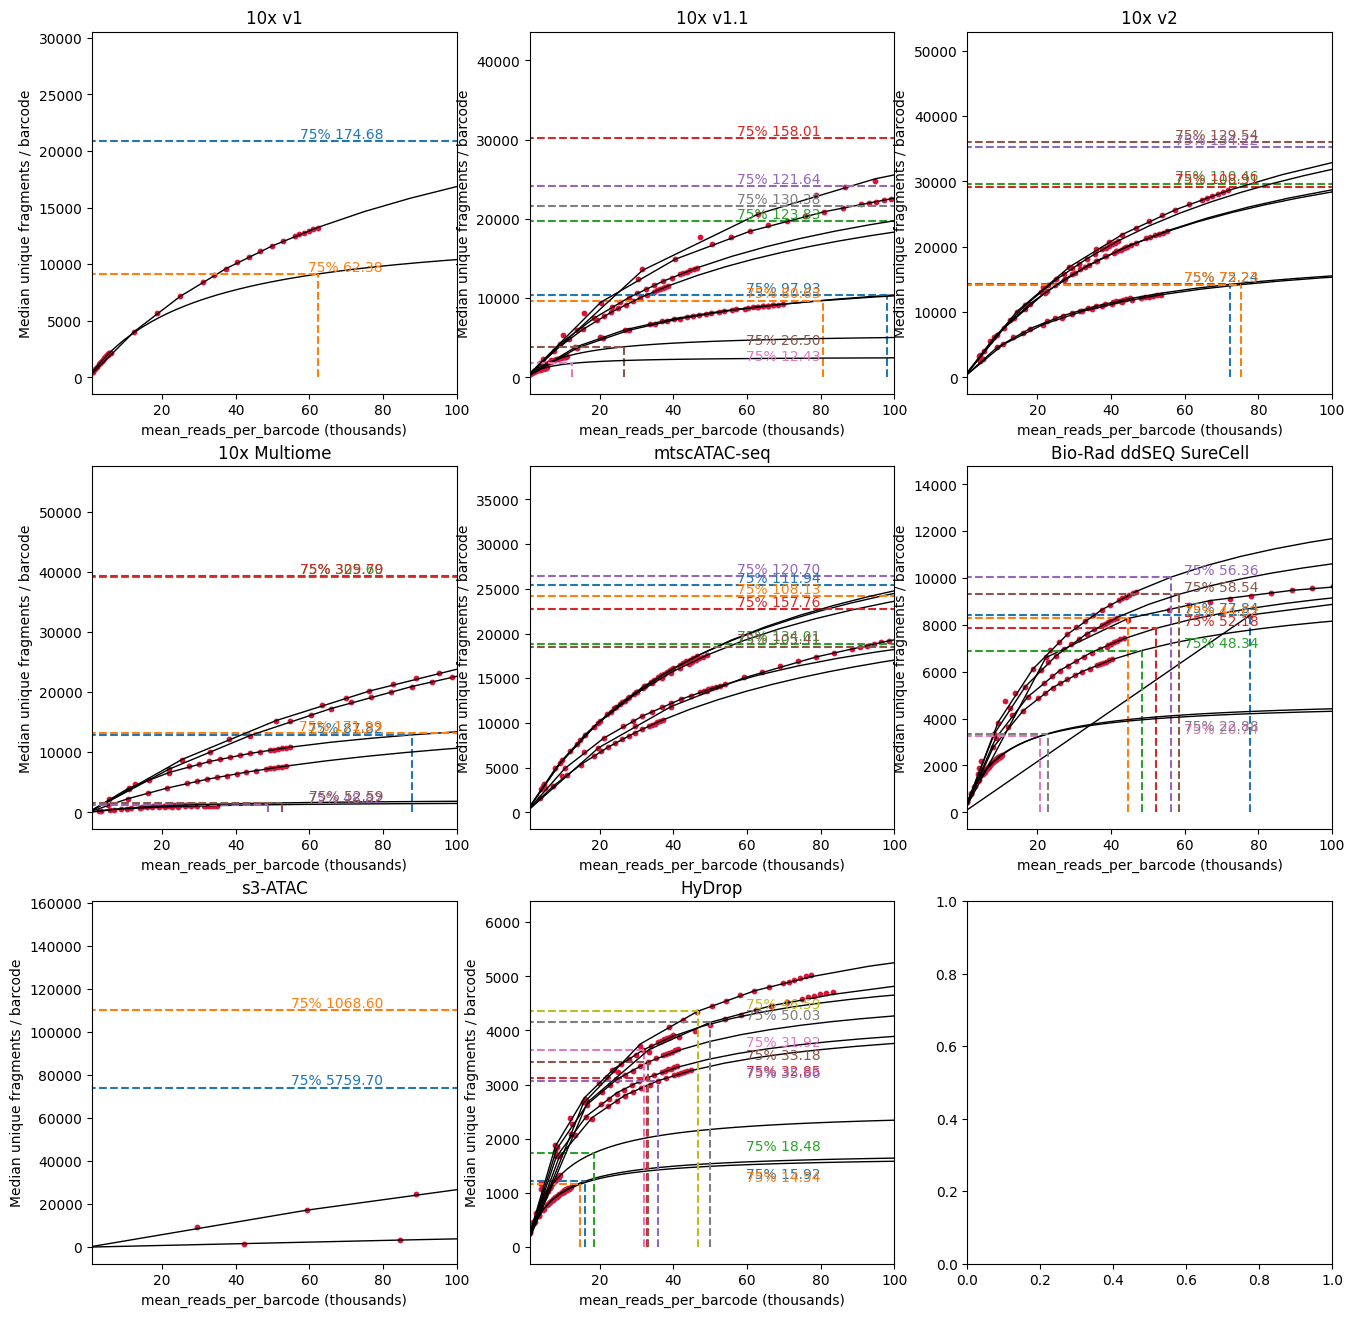

In [19]:
x_axis = "mean_reads_per_barcode"
# y_axis = "duplication_rate"
y_axis = "median_uniq_frag_per_bc"
plot_current_saturation = False
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig, axes = plt.subplots(3, 3, figsize=(16, 16))  # , sharex=True, sharey=True)

for tech in tech_order:
    # for tech in ["ddseq"]:
    print(tech)
    ax = axes.flatten()[list(tech_order).index(tech)]
    colors = sns.color_palette(
        "husl",
        len(list(samples_order_dict_bytech.keys())),
    )
    palette = {}

    for idx, sample in enumerate(samples_order_dict_bytech[tech]):
        print(sample)
        palette[sample] = sns.color_palette("tab10")[idx]

        stats_df = pd.read_csv(sampling_stats_path_dict[sample], sep="\t", index_col=0)

        # Fit'n'plot for total count.
        n_reads = df_reads.loc[sample]["reads"]

        stats_df["total_reads"] = n_reads * stats_df.index

        stats_df["mean_reads_per_barcode"] = (
            stats_df["total_reads"] / stats_df["cell_barcode_count"]
        )
        stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
        # stats_df["duplication_rate"] = (stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]/stats_df["total_frag_count"])
        # select x/y data fro MM fit from subsampling stats
        x_data = np.array(stats_df.loc[0:, x_axis]) / 10 ** 3
        y_data = np.array(stats_df.loc[0:, y_axis])
        # fit to MM function

        best_fit_ab, covar = curve_fit(MM, x_data, y_data, bounds=(0, +np.inf))

        # expand fit space
        x_fit = np.linspace(0, int(np.max(x_data) * 100), num=500)
        y_fit = MM(x_fit, *(best_fit_ab))
        # impute maximum saturation to plot as 95% of y_max
        y_val = best_fit_ab[0] * 0.95
        # subset x_fit space if bigger then y_val
        if y_val < max(y_fit):
            x_coef = np.where(y_fit >= y_val)[0][0]
            x_fit = x_fit[0:x_coef]
            y_fit = y_fit[0:x_coef]

        # plot model
        ax.plot(x_fit, MM(x_fit, *best_fit_ab), label="fitted", c="black", linewidth=1)
        # plot raw data
        ax.scatter(x=x_data, y=y_data, c="crimson", s=10)
        # mark curent saturation
        if plot_current_saturation == True:
            x_idx = np.where(y_fit >= max(y_data))[0][0]
            x_coef = x_fit[x_idx]
            y_coef = y_fit[x_idx]
            ax.plot([x_coef, x_coef], [0, y_coef], linestyle="--", c="crimson")
            ax.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="crimson")
            ax.text(
                x=x_coef,
                y=y_coef,
                s=str(round(100 * max(y_data) / best_fit_ab[0]))
                + "% {:.2f}".format(x_coef),
                c="crimson",
                ha="right",
                va="bottom",
            )

        percentages = [0.75]
        for perc in percentages:
            # Find read count for percent saturation
            y_val = best_fit_ab[0] * 0.9 * perc
            # Find closest match in fit
            if max(y_fit) > y_val:
                x_idx = np.where(y_fit >= y_val)[0][0]
                x_coef = x_fit[x_idx]
                y_coef = y_fit[x_idx]
                # Draw vline
                ax.plot(
                    [x_coef, x_coef], [0, y_coef], linestyle="--", c=palette[sample]
                )
                # Draw hline
                ax.plot(
                    [0, x_coef], [y_coef, y_coef], linestyle="--", c=palette[sample]
                )
                # Plot imputed read count
                ax.text(
                    x=80,
                    y=y_coef,
                    s=str(round(100 * perc)) + "% {:.2f}".format(x_coef),
                    c=palette[sample],
                    ha="right",
                    va="bottom",
                )

    # save figure
    ax.set_xlabel(format_axis(x_axis) + " (thousands)")
    ax.set_xlim([1, 100])
    # plt.ylim([10, 40000])

    # plt.yscale("log")
    # ax.set_xscale("log")

    ax.set_ylabel(format_axis(y_axis))
    ax.set_title(tech_alias_dict[tech])

# plt.savefig("saturation_stats/all.svg", dpi=600)
plt.show()

plt.close()

In [20]:
import glob
import seaborn as sns

In [21]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob("saturation_stats/*.sampling_stats_updated.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_1.FULL': 'saturation_stats/BIO_ddseq_1.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_2.FULL': 'saturation_stats/BIO_ddseq_2.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_3.FULL': 'saturation_stats/BIO_ddseq_3.FULL.sampling_stats_updated.tsv',
 'BIO_ddseq_4.FULL': 'saturation_stats/BIO_ddseq_4.FULL.sampling_stats_updated.tsv',
 'BRO_mtscatac_1.FULL': 'saturation_stats/BRO_mtscatac_1.FULL.sampling_stats_updated.tsv',
 'BRO_mtscatac_2.FULL': 'saturation_stats/BRO_mtscatac_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xmultiome_1.FULL': 'saturation_stats/CNA_10xmultiome_1.FULL.sampling_stats_updated.tsv',
 'CNA_10xmultiome_2.FULL': 'saturation_stats/CNA_10xmultiome_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_1.FULL': 'saturation_stats/CNA_10xv11_1.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_2.FULL': 'saturation_stats/CNA_10xv11_2.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_3.FULL': 'saturation_stats/CNA_10xv11_3.FULL.sampling_stats_updated.tsv',
 'CNA_10xv11_4.FULL': '

In [22]:
def MM_dup(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

10xv1
VIB_10xv1_1.FULL
VIB_10xv1_2.FULL
10xv11
CNA_10xv11_1.FULL
CNA_10xv11_2.FULL
CNA_10xv11_3.FULL
CNA_10xv11_4.FULL
CNA_10xv11_5.FULL
STA_10xv11_1.FULL
STA_10xv11_2.FULL
TXG_10xv11_1.FULL
10xv2
CNA_10xv2_1.FULL
CNA_10xv2_2.FULL
TXG_10xv2_1.FULL
TXG_10xv2_2.FULL
VIB_10xv2_1.FULL
VIB_10xv2_2.FULL
10xmultiome
CNA_10xmultiome_1.FULL
CNA_10xmultiome_2.FULL
SAN_10xmultiome_1.FULL
SAN_10xmultiome_2.FULL
VIB_10xmultiome_1.FULL
VIB_10xmultiome_2.FULL
mtscatac
BRO_mtscatac_1.FULL
BRO_mtscatac_2.FULL
CNA_mtscatac_1.FULL
CNA_mtscatac_2.FULL
MDC_mtscatac_1.FULL
MDC_mtscatac_2.FULL
ddseq
BIO_ddseq_1.FULL
BIO_ddseq_2.FULL
BIO_ddseq_3.FULL
BIO_ddseq_4.FULL
HAR_ddseq_1.FULL
HAR_ddseq_2.FULL
UCS_ddseq_1.FULL
UCS_ddseq_2.FULL
s3atac
OHS_s3atac_1.FULL
OHS_s3atac_2.FULL
hydrop
CNA_hydrop_1.FULL
CNA_hydrop_2.FULL
CNA_hydrop_3.FULL
EPF_hydrop_1.FULL
EPF_hydrop_2.FULL
EPF_hydrop_3.FULL
EPF_hydrop_4.FULL
VIB_hydrop_1.FULL
VIB_hydrop_2.FULL


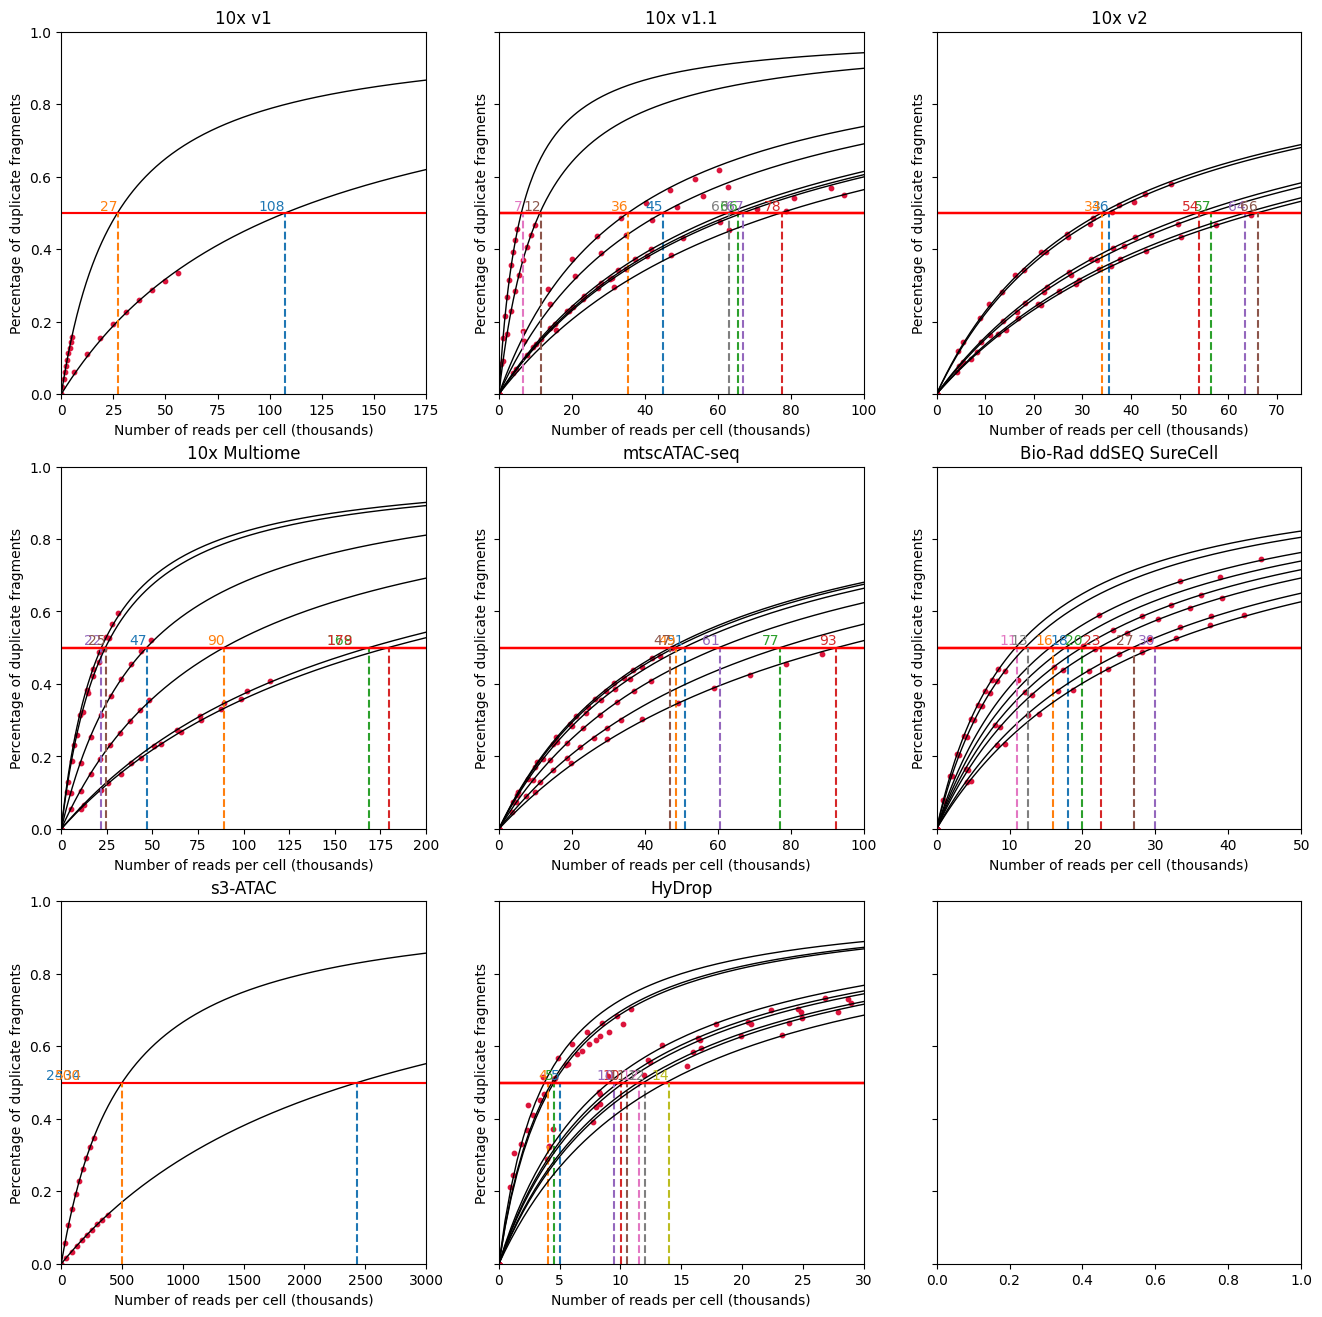

In [23]:
x_axis = "mean_reads_per_barcode"
y_axis = "duplication_rate"

x_max_dict = {
    "10xv1": 175,
    "10xv11": 100,
    "10xv2": 75,
    "10xmultiome": 200,
    "mtscatac": 100,
    "ddseq": 50,
    "s3atac": 3000,
    "hydrop": 30,
}
# y_axis = "median_uniq_frag_per_bc"
plot_current_saturation = False
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
x_max = 200
df_saturation = pd.DataFrame()
fig, axes = plt.subplots(
    3, 3, figsize=(16, 16), sharex=False, sharey=True
)  # , sharex=True, sharey=True)

for tech in tech_order:
    # for tech in ["ddseq"]:
    print(tech)
    ax = axes.flatten()[list(tech_order).index(tech)]
    colors = sns.color_palette(
        "husl",
        len(list(samples_order_dict_bytech.keys())),
    )
    palette = {}

    for idx, sample in enumerate(samples_order_dict_bytech[tech]):
        if sample in sampling_stats_path_dict.keys():
            print(sample)
            palette[sample] = sns.color_palette("tab10")[idx]

            stats_df = pd.read_csv(
                sampling_stats_path_dict[sample], sep="\t", index_col=0
            )
            stats_df.drop(1.0, inplace=True)
            # Fit'n'plot for total count.
            n_reads = df_reads.loc[sample]["reads"]

            stats_df["total_reads"] = n_reads * stats_df.index

            stats_df["mean_reads_per_barcode"] = (
                stats_df["total_reads"] / stats_df["cell_barcode_count"]
            )
            stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
            stats_df["duplication_rate"] = (
                stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]
            ) / stats_df["total_frag_count"]
            stats_df["duplication_rate"].fillna(0, inplace=True)
            # print(stats_df["duplication_rate"])
            # select x/y data fro MM fit from subsampling stats
            x_data = np.array(stats_df.loc[0:, x_axis]) / 10 ** 3
            y_data = np.array(stats_df.loc[0:, y_axis])
            # fit to MM function

            best_fit_ab, covar = curve_fit(MM_dup, x_data, y_data, bounds=(0, +np.inf))

            # expand fit space
            x_fit = np.linspace(0, 5000, num=10000)
            y_fit = MM_dup(x_fit, *(best_fit_ab))
            # impute maximum saturation to plot as 95% of y_max
            y_val = best_fit_ab[0] * 0.95
            # subset x_fit space if bigger then y_val
            if y_val < max(y_fit):
                x_coef = np.where(y_fit >= y_val)[0][0]
                x_fit = x_fit[0:x_coef]
                y_fit = y_fit[0:x_coef]

            # plot model
            ax.plot(
                x_fit, MM_dup(x_fit, *best_fit_ab), label="fitted", c="black", linewidth=1
            )
            # plot raw data
            ax.scatter(x=x_data, y=y_data, c="crimson", s=10)
            # mark curent saturation
            if plot_current_saturation == True:
                x_idx = np.where(y_fit >= max(y_data))[0][0]
                x_coef = x_fit[x_idx]
                y_coef = y_fit[x_idx]
                ax.plot([x_coef, x_coef], [0, y_coef], linestyle="--", c="crimson")
                ax.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="crimson")
                ax.text(
                    x=x_coef,
                    y=y_coef,
                    s=str(round(100 * max(y_data) / best_fit_ab[0]))
                    + "% {:.2f}".format(x_coef),
                    c="crimson",
                    ha="right",
                    va="bottom",
                )

            percentages = [0.5]
            for perc in percentages:
                # Find read count for percent saturation
                # y_val = best_fit_ab[0] * perc
                y_val = perc
                # Draw hline
                ax.hlines(y=perc, xmin=0, xmax=4000, color="red")
                # Find closest match in fit
                if max(y_fit) > y_val:
                    x_idx = np.where(y_fit >= y_val)[0][0]
                    x_coef = x_fit[x_idx]
                    # y_coef = y_fit[x_idx]
                    y_coef = y_val
                    # Draw vline
                    ax.plot(
                        [x_coef, x_coef], [0, y_coef], linestyle="--", c=palette[sample]
                    )

                    # Plot imputed read count
                    if x_coef < x_max * 0.8:
                        ax.text(
                            x=x_coef,
                            y=perc,
                            s=int(round(x_coef)),
                            c=palette[sample],
                            ha="right",
                            va="bottom",
                        )
                    else:
                        ax.text(
                            x=x_max * 0.8,
                            y=perc,
                            s=str(int(x_coef)),
                            c=palette[sample],
                            ha="right",
                            va="bottom",
                        )
                df_saturation.at[sample, f"saturation {perc}"] = x_coef

                # now calculate the expected fragment recovery at this x_coef
                y_data = np.array(stats_df.loc[0:, "median_uniq_frag_per_bc"])
                best_fit_ab, covar = curve_fit(MM, x_data, y_data, bounds=(0, +np.inf))

                # expand fit space
                x_fit = np.linspace(0, x_coef, num=2000)
                y_fit = MM(x_fit, *(best_fit_ab))

                expected_frags = y_fit[-1]

                df_saturation.at[sample, "median_uniq_frag_per_bc"] = expected_frags

        # save figure
        ax.set_xlabel("Number of reads per cell (thousands)")
        ax.set_xlim([0, x_max_dict[tech]])
        ax.set_ylim([0, 1])
        # ax.legend()

        # plt.yscale("log")
        # ax.set_xscale("log")

        ax.set_ylabel("Percentage of duplicate fragments")
        ax.set_title(tech_alias_dict[tech])

plt.savefig("saturation_stats/all.svg", dpi=600)
plt.savefig("saturation_stats/all.png", dpi=300, facecolor="white")

plt.show()

plt.close()

In [24]:
df_saturation.index = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in df_saturation.index
]
df_saturation["tech"] = [x.split("_")[1] for x in df_saturation.index]
df_saturation

,saturation 0.5,median_uniq_frag_per_bc,tech
VIB_10xv1_1.FULL,107.510751,17405.277473,10xv1
VIB_10xv1_2.FULL,27.002700,6393.961168,10xv1
CNA_10xv11_1.FULL,45.004500,7689.908492,10xv11
CNA_10xv11_2.FULL,35.503550,6978.303100,10xv11
CNA_10xv11_3.FULL,65.506551,15370.334938,10xv11
CNA_10xv11c_1.FULL,77.507751,22884.441523,10xv11c
CNA_10xv11c_2.FULL,67.006701,19294.761413,10xv11c
STA_10xv11_1.FULL,11.501150,2733.016075,10xv11
STA_10xv11_2.FULL,6.500650,1370.451278,10xv11
TXG_10xv11_1.FULL,63.006301,16261.350590,10xv11


In [25]:
round(df_saturation.groupby("tech")["saturation 0.5"].median())

tech
10xmultiome       68.0
10xv1             67.0
10xv11            40.0
10xv11c           72.0
10xv2             55.0
ddseq             19.0
hydrop            10.0
mtscatac          69.0
mtscatacfacs      50.0
s3atac          1467.0
Name: saturation 0.5, dtype: float64

In [26]:
round(df_saturation.groupby("tech")["median_uniq_frag_per_bc"].median())

tech
10xmultiome     10155.0
10xv1           11900.0
10xv11           7334.0
10xv11c         21090.0
10xv2           22427.0
ddseq            5249.0
hydrop           1884.0
mtscatac        16976.0
mtscatacfacs    17929.0
s3atac          66130.0
Name: median_uniq_frag_per_bc, dtype: float64

In [38]:
stats_df_merged = pd.DataFrame()
for tech in tech_order:
    # for tech in ["ddseq"]:
    print(tech)
    ax = axes.flatten()[list(tech_order).index(tech)]
    colors = sns.color_palette(
        "husl",
        len(list(samples_order_dict_bytech.keys())),
    )
    palette = {}

    for idx, sample in enumerate(samples_order_dict_bytech[tech]):
        if sample in sampling_stats_path_dict.keys():
            print(sample)
            palette[sample] = sns.color_palette("tab10")[idx]

            stats_df = pd.read_csv(
                sampling_stats_path_dict[sample], sep="\t", index_col=0
            )
            stats_df.drop(1.0, inplace=True)
            # Fit'n'plot for total count.
            n_reads = df_reads.loc[sample]["reads"]

            stats_df["total_reads"] = n_reads * stats_df.index

            stats_df["mean_reads_per_barcode"] = (
                stats_df["total_reads"] / stats_df["cell_barcode_count"]
            )
            stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
            stats_df["duplication_rate"] = (
                stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]
            ) / stats_df["total_frag_count"]
            stats_df["duplication_rate"].fillna(0, inplace=True)
            # print(stats_df["duplication_rate"])
            stats_df["sampling_fraction"] = stats_df.index
            stats_df["sample"] = sample
            
            stats_df_merged = pd.concat([stats_df_merged, stats_df])

10xv1
VIB_10xv1_1.FULL
VIB_10xv1_2.FULL
10xv11
CNA_10xv11_1.FULL
CNA_10xv11_2.FULL
CNA_10xv11_3.FULL
CNA_10xv11_4.FULL
CNA_10xv11_5.FULL
STA_10xv11_1.FULL
STA_10xv11_2.FULL
TXG_10xv11_1.FULL
10xv2
CNA_10xv2_1.FULL
CNA_10xv2_2.FULL
TXG_10xv2_1.FULL
TXG_10xv2_2.FULL
VIB_10xv2_1.FULL
VIB_10xv2_2.FULL
10xmultiome
CNA_10xmultiome_1.FULL
CNA_10xmultiome_2.FULL
SAN_10xmultiome_1.FULL
SAN_10xmultiome_2.FULL
VIB_10xmultiome_1.FULL
VIB_10xmultiome_2.FULL
mtscatac
BRO_mtscatac_1.FULL
BRO_mtscatac_2.FULL
CNA_mtscatac_1.FULL
CNA_mtscatac_2.FULL
MDC_mtscatac_1.FULL
MDC_mtscatac_2.FULL
ddseq
BIO_ddseq_1.FULL
BIO_ddseq_2.FULL
BIO_ddseq_3.FULL
BIO_ddseq_4.FULL
HAR_ddseq_1.FULL
HAR_ddseq_2.FULL
UCS_ddseq_1.FULL
UCS_ddseq_2.FULL
s3atac
OHS_s3atac_1.FULL
OHS_s3atac_2.FULL
hydrop
CNA_hydrop_1.FULL
CNA_hydrop_2.FULL
CNA_hydrop_3.FULL
EPF_hydrop_1.FULL
EPF_hydrop_2.FULL
EPF_hydrop_3.FULL
EPF_hydrop_4.FULL
VIB_hydrop_1.FULL
VIB_hydrop_2.FULL


In [46]:
stats_df_merged.reset_index(drop=True).to_csv("derop_sourcedata_extended_fig13.csv")

In [42]:
?stats_df_merged.reset_index

Signature:
stats_df_merged.reset_index(
    level: 'IndexLabel' = None,
    *,
    drop: 'bool' = False,
    inplace: 'bool' = False,
    col_level: 'Hashable' = 0,
    col_fill: 'Hashable' = '',
    allow_duplicates: 'bool | lib.NoDefault' = <no_default>,
    names: 'Hashable | Sequence[Hashable]' = None,
) -> 'DataFrame | None'
Docstring:
Reset the index, or a level of it.

Reset the index of the DataFrame, and use the default one instead.
If the DataFrame has a MultiIndex, this method can remove one or more
levels.

Parameters
----------
level : int, str, tuple, or list, default None
    Only remove the given levels from the index. Removes all levels by
    default.
drop : bool, default False
    Do not try to insert index into dataframe columns. This resets
    the index to the default integer index.
inplace : bool, default False
    Whether to modify the DataFrame rather than creating a new one.
col_level : int or str, default 0
    If the columns have multiple levels, determines 

In [33]:
stats_df

,mean_frag_per_bc,median_uniq_frag_per_bc,total_unique_frag_count,total_frag_count,cell_barcode_count,total_reads,mean_reads_per_barcode,duplication_rate,sampling_fraction,sample
sampling_fraction,,,,,,,,,,
0.0,0.000000,0.0,0,0,0,0.0,0.000000,0.000000,0.0,VIB_hydrop_2.FULL
0.1,3867.947284,1751.0,7363608,12106675,3130,24255605.9,7749.394856,0.391773,0.1,VIB_hydrop_2.FULL
0.2,7736.429393,2676.0,11011517,24215024,3130,48511211.8,15498.789712,0.545261,0.2,VIB_hydrop_2.FULL
0.3,11601.450479,3276.5,13365718,36312540,3130,72766817.7,23248.184569,0.631926,0.3,VIB_hydrop_2.FULL
0.4,15470.392652,3700.0,15073128,48422329,3130,97022423.6,30997.579425,0.688715,0.4,VIB_hydrop_2.FULL
0.5,19339.057508,4050.0,16393830,60531250,3130,121278029.5,38746.974281,0.729167,0.5,VIB_hydrop_2.FULL
0.6,23205.938978,4334.5,17458642,72634589,3130,145533635.4,46496.369137,0.759637,0.6,VIB_hydrop_2.FULL
0.7,27073.820767,4546.0,18348899,84741059,3130,169789241.3,54245.763994,0.783471,0.7,VIB_hydrop_2.FULL
0.8,30942.521725,4719.0,19105426,96850093,3130,194044847.2,61995.158850,0.802732,0.8,VIB_hydrop_2.FULL
